In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import eli5
import xarray as xr
from eli5.sklearn import PermutationImportance
import os
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cdo


### Données brutes

In [2]:
file1 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test1.csv'
file2 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test2.csv'
file3 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test3.csv'
file4 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test4.csv'
file5 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_test5.csv'

In [3]:
file_list=[file1,file2,file3,file4,file5]
  
dataset = pd.DataFrame(pd.read_csv(file_list[0]))
  
for i in range(1,len(file_list)):
    data = pd.read_csv(file_list[i])
    df = pd.DataFrame(data)
    dataset = pd.concat([dataset,df])

In [4]:
dataset.head()

,hotel_id,price,stock,city,date,language,mobile,avatar_id,group,brand,parking,pool,children_policy
0,918,336,23,amsterdam,14,dutch,0,59852,Morriott International,Corlton,1,1,0
1,442,190,19,amsterdam,14,dutch,0,59852,Accar Hotels,Marcure,0,0,0
2,588,173,0,amsterdam,14,dutch,0,59852,Independant,Independant,0,0,0
3,807,323,17,amsterdam,14,dutch,0,59852,Chillton Worldwide,Chill Garden Inn,0,1,0
4,271,81,0,amsterdam,14,dutch,0,59852,Independant,Independant,1,0,0


<AxesSubplot:>

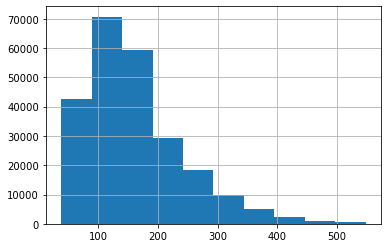

In [5]:
#on trace la distribution de la cible
dataset['price'].hist()

array([[<AxesSubplot:xlabel='price', ylabel='price'>,
        <AxesSubplot:xlabel='stock', ylabel='price'>,
        <AxesSubplot:xlabel='date', ylabel='price'>],
       [<AxesSubplot:xlabel='price', ylabel='stock'>,
        <AxesSubplot:xlabel='stock', ylabel='stock'>,
        <AxesSubplot:xlabel='date', ylabel='stock'>],
       [<AxesSubplot:xlabel='price', ylabel='date'>,
        <AxesSubplot:xlabel='stock', ylabel='date'>,
        <AxesSubplot:xlabel='date', ylabel='date'>]], dtype=object)

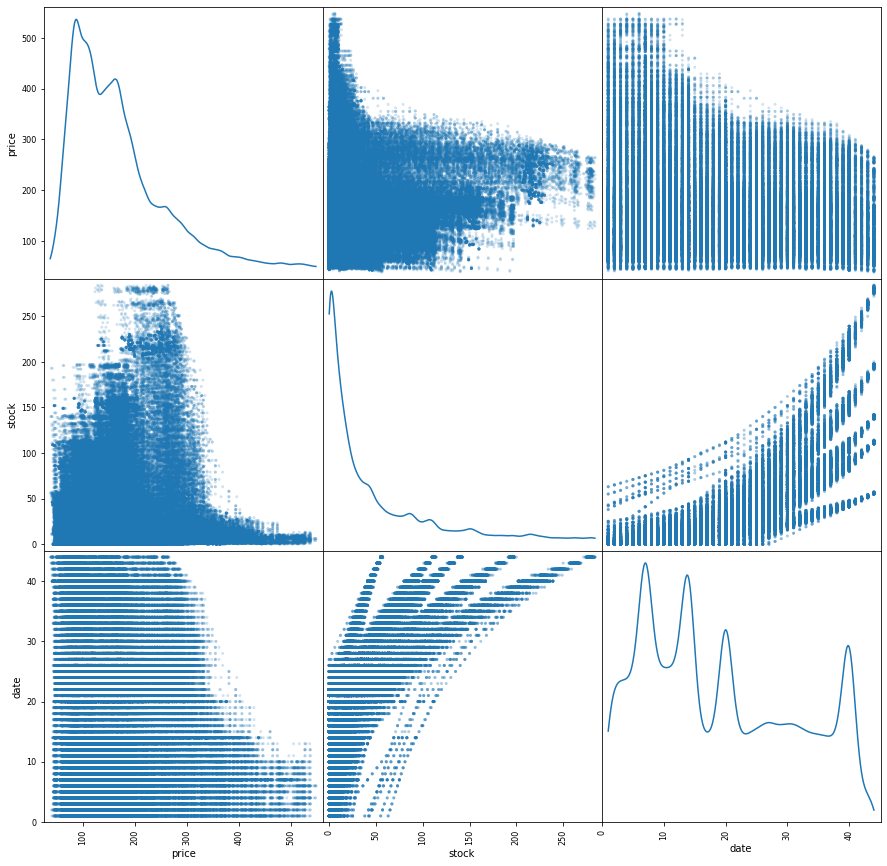

In [6]:
scatter_matrix(dataset[["price","stock","date"]], alpha=0.2, figsize=(15, 15), diagonal='kde')

### Données du test set

In [23]:
# test sur le jeu de données test pour la soumission
file_test = '/home/enora/Documents/insa/IA/defi_IA-main/test_set.csv'
hotel_features = pd.read_csv('/home/enora/Documents/insa/IA/defi_IA-main/features_hotels.csv',index_col=['hotel_id', 'city'])

dataset_test = pd.DataFrame(pd.read_csv(file_test,index_col=0))
X_dataset_test= dataset_test.drop(labels=['order_requests'], axis=1)
X_dataset_test = X_dataset_test.join(hotel_features, on=['hotel_id', 'city'])
X_dataset_test.head()

,city,date,language,mobile,avatar_id,hotel_id,stock,group,brand,parking,pool,children_policy
index,,,,,,,,,,,,
0,vilnius,21,romanian,0,1,161,46,Boss Western,J.Halliday Inn,1,0,0
1,vilnius,21,romanian,0,1,187,32,Accar Hotels,Marcure,1,1,0
2,vilnius,21,romanian,0,1,279,12,Independant,Independant,1,0,0
3,vilnius,21,romanian,0,1,395,10,Accar Hotels,Ibas,0,0,0
4,vilnius,21,romanian,0,1,488,42,Accar Hotels,Safitel,1,1,1


Lorsqu'on crée notre jeu de données, nous pouvons agir sur la ville, la langue, l'avatar, la date, le mobile. Nous allons ainsi regarder plus précisemment ces variables du test set afin d'agrandir notre jeu de données de façon ciblée.

(array([1864., 1351.,    0.,  267., 1059.,  520.,    0.,    0.,  486.,
        1097.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <BarContainer object of 10 artists>)

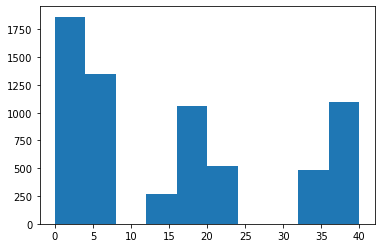

In [24]:
# Date :
plt.hist(X_dataset_test.date)

On remarque que les dates comprises entre J0 et J-7 sont majoritaires, nous avons également un certain nombre de "demandes" pour des dates entre J-12 et J-24 puis entre J-32 et J-40. 

In [55]:
# langue :
langues = X_dataset_test.groupby(['language'])['language'].count()
nom = langues.index
nbe= langues.values
# langues = pd.DataFrame(langues)
# langues['language']
df = pd.DataFrame({

    'langue': nom,

    'value': nbe,


})
df.sort_values(by=['value'],ascending=False)

,langue,value
13,hungarian,967
9,finnish,466
0,austrian,461
22,romanian,439
23,slovakian,418
26,swedish,404
8,estonian,390
2,bulgarian,356
6,danish,346
14,irish,209


On se rend compte que certaines langues sont bien plus utilisées que d'autres. On va donc agrandir notre jeu de données en se concentrant sur ces langues ci : hungarian, finnish, austrian, romanian, slovakian, swedish, estonian, bulgarian et danish.

In [56]:
# ville :
villes = X_dataset_test.groupby(['city'])['city'].count()
nom = villes.index
nbe= villes.values
# langues = pd.DataFrame(langues)
# langues['language']
df = pd.DataFrame({

    'ville': nom,

    'value': nbe,

})
df.sort_values(by=['value'],ascending=False)

,ville,value
0,amsterdam,1134
3,paris,1125
2,madrid,1094
1,copenhagen,723
4,rome,721
8,vilnius,609
7,vienna,568
5,sofia,374
6,valletta,296


Les villes les plus représentées sont : Amsterdam, Paris et Madrid

(array([3630.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3014.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

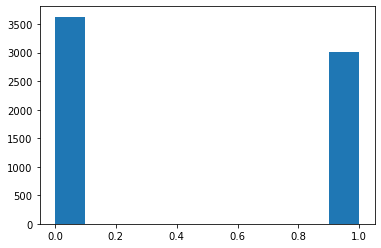

In [57]:
#mobile
plt.hist(X_dataset_test.mobile)

La différence entre le téléphone et l'ordinateur n'est pas très grande, on peut continuer à choisir aléatoirement

### Préparation des données
Dans cette partie on transforme les variables qualitatives en les encodant de deux manières différentes : avec One Hot Encoder et avec Target Encoder

In [9]:
# Variables explicatives

#encodage avec OneHotEncoder

from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
enc_data=pd.DataFrame(enc.fit_transform(dataset[["city","language","group","brand"]]).toarray())
df_ohe=dataset.join(enc_data)
one_hot_encoded_data = pd.get_dummies(dataset, columns = ["city","language","group","brand"])

X_ohe = one_hot_encoded_data.drop(labels='price',axis=1)
Y_ohe = one_hot_encoded_data .price
X_ohe

,hotel_id,stock,date,mobile,avatar_id,parking,pool,children_policy,city_amsterdam,city_copenhagen,...,brand_Ibas,brand_Independant,brand_J.Halliday Inn,brand_Marcure,brand_Morriot,brand_Navatel,brand_Quadrupletree,brand_Royal Lotus,brand_Safitel,brand_Tripletree
0,918,23,14,0,59852,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,442,19,14,0,59852,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,588,0,14,0,59852,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,807,17,14,0,59852,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,271,0,14,0,59852,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88821,179,0,1,1,259168,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
88822,428,0,1,1,259168,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88823,315,2,1,1,259168,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88824,494,0,1,1,259168,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


On observe les corrélations 

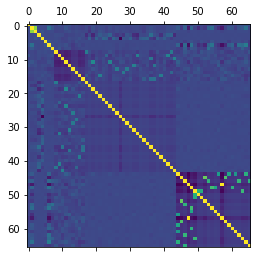

In [11]:
X_ohe.corr()
plt.matshow(X_ohe.corr())
plt.show()

FAIRE UN COMMENTAIRE

In [ ]:
# Variables explicatives

#encodage avec Target Encoder


### Extraction des échantillons apprentissage et test

In [13]:
from sklearn.model_selection import train_test_split  
X_train,X_test,Y_train,Y_test=train_test_split(X_ohe,Y_ohe,test_size=0.1)

### Modèle random forest

In [14]:
rf = RandomForestRegressor(max_depth=10)

In [15]:
rf.fit(X_train, Y_train)
print(f"Random forest score: {rf.score(X_test, Y_test):.2f}")

Random forest score: 0.89


### Modèle XGBoost

In [16]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

In [17]:
xgb.fit(X_train,Y_train)
print(f"XGBoost score: {xgb.score(X_test, Y_test):.2f}")

XGBoost score: 0.98


### Feature Importance

On trace les features par ordre d'importance pour les deux modèles testés (random forest et XGBoost)

In [18]:
feature_names = list(X_ohe.columns.values)
#feature_names

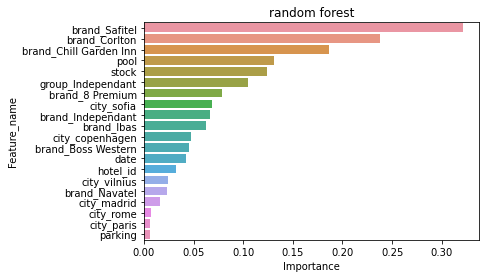

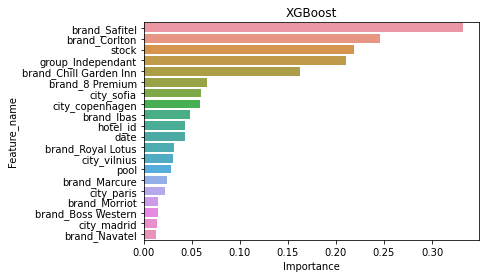

In [20]:
import seaborn as sns

features_importance_dict = {}
for model, name in zip([rf,xgb], ['random forest','XGBoost']):
    plt.figure()
    permumtation_impor = PermutationImportance(model, random_state=0).fit(X_test, Y_test)
    features_importance = {'Feature_name':feature_names, 'Importance':permumtation_impor.feature_importances_}  
    features_importance = pd.DataFrame(features_importance) 
    features_importance = features_importance.sort_values(['Importance'], ascending=False) 
    features_importance_dict[name] = features_importance
    ax = sns.barplot(x="Importance", y="Feature_name", data=features_importance[0:20])
    plt.title(name)

On regroupe les features par catégories 

In [60]:
features_importance_dict['random forest']
Feature_name = features_importance_dict['random forest']['Feature_name'].tolist()
Importance = features_importance_dict['random forest']['Importance'].tolist()

Feature_name2 = ['city','language', 'group','brand','hotel_id','stock','date','mobile','avatar_id','parking','pool','children_policy']
Importance2 = [0 for i in range(len(Feature_name2))]

for i in range(len(Feature_name)):
    if Feature_name[i][0:4]=='city':
        Importance2[0]=Importance2[0]+Importance[i]
    
    if Feature_name[i][0:8]=='language':
        Importance2[1]=Importance2[1]+Importance[i]  
   
    if Feature_name[i][0:5]=='group':
        Importance2[2]=Importance2[2]+Importance[i]  
        
    if Feature_name[i][0:5]=='brand':
        Importance2[3]=Importance2[3]+Importance[i]  

for j in range(4,len(Feature_name2)):
    Importance2[j]= Importance[Feature_name.index(Feature_name2[j])]     
        
Importance2      
features_importance2 = pd.DataFrame(list(zip(Feature_name2, Importance2)),columns =['Feature_name2', 'Importance2'])
features_importance2


,Feature_name2,Importance2
0,city,1.731162e-01
1,language,2.665131e-04
2,group,1.049437e-01
3,brand,1.022472e+00
4,hotel_id,3.273440e-02
5,stock,1.238320e-01
6,date,4.238042e-02
7,mobile,8.599671e-07
8,avatar_id,1.433806e-05
9,parking,6.081332e-03


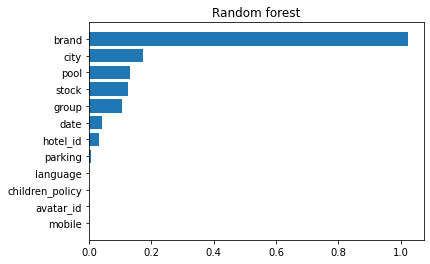

In [62]:
# Create a data frame
df = pd.DataFrame ({
        'Group':  features_importance2['Feature_name2'],
        'Value': features_importance2['Importance2']
})

# Sort the table
df = df.sort_values(by=['Value'])

# Create horizontal bars
plt.barh(y=df.Group, width=df.Value);

# Add title
plt.title('Random forest');

Parking, language, children_policy, avatar_id, mobile n'ont pas d'importance 

In [63]:
features_importance_dict['XGBoost']
Feature_name = features_importance_dict['XGBoost']['Feature_name'].tolist()
Importance_xgb = features_importance_dict['XGBoost']['Importance'].tolist()

Feature_name2 = ['city','language', 'group','brand','hotel_id','stock','date','mobile','avatar_id','parking','pool','children_policy']
Importance2_xgb = [0 for i in range(len(Feature_name2))]

for i in range(len(Feature_name)):
    if Feature_name[i][0:4]=='city':
        Importance2_xgb[0]=Importance2_xgb[0]+Importance_xgb[i]
    
    if Feature_name[i][0:8]=='language':
        Importance2_xgb[1]=Importance2_xgb[1]+Importance_xgb[i]  
   
    if Feature_name[i][0:5]=='group':
        Importance2_xgb[2]=Importance2_xgb[2]+Importance_xgb[i]  
        
    if Feature_name[i][0:5]=='brand':
        Importance2_xgb[3]=Importance2_xgb[3]+Importance_xgb[i]  

for j in range(4,len(Feature_name2)):
    Importance2_xgb[j]= Importance_xgb[Feature_name.index(Feature_name2[j])]     
        
Importance2_xgb   
features_importance2 = pd.DataFrame(list(zip(Feature_name2, Importance2_xgb)),columns =['Feature_name2', 'Importance2_xgb'])
features_importance2


,Feature_name2,Importance2_xgb
0,city,0.195487
1,language,0.004746
2,group,0.225753
3,brand,0.964304
4,hotel_id,0.043006
5,stock,0.218754
6,date,0.042943
7,mobile,0.000038
8,avatar_id,0.000975
9,parking,0.002219


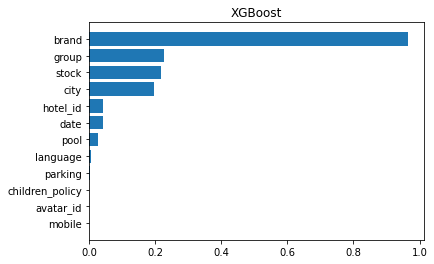

In [64]:
# Create a data frame
df = pd.DataFrame ({
        'Group':  features_importance2['Feature_name2'],
        'Value': features_importance2['Importance2_xgb']
})

# Sort the table
df = df.sort_values(by=['Value'])

# Create horizontal bars
plt.barh(y=df.Group, width=df.Value);

# Add title
plt.title('XGBoost');

De même, Parking, language, children_policy, avatar_id, mobile n'ont pas d'importance 